Alumnos:

- Fabian Nova
- Effry Vigorena
- Wilder Prado
- Felipe Guzmán


In [1]:
# Importando librerias
import pandas as pd
import numpy as np
import sweetviz as sv
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot  as plt
import seaborn as sns
import networkx as nx


In [68]:
## Funciones para procesar datos
'''
Funcion que permite cambiar datos de textos
'''
def cambiando_datos_texto(df_, columns_):
        cat_numeric = LabelEncoder()
        return pd.DataFrame(cat_numeric.fit_transform(df_[[columns_]]))
    
# 
def get_community_matrix(A, com):
    n = len(A)
    
    # número de comunidades
    nc = len(set(com))

    # Inicializar lista de matrices de adyacencia
    e = np.zeros((nc, nc))

    # Crea enlace y normaliza valores dividiendo por la suma de todos los enlaces (dependiente del tamaño de la red)
    m = 0
    for i in range(n):
        for j in range(n):
            if A[i, j] != 0:
                ic = com[i]
                jc = com[j]
                if ic == jc:
                    e[ic,ic] += A[i, j]
                else:
                    e[ic,jc] += 0.5*A[i,j]
                    e[jc,ic] = e[ic,jc]
                m += A[i,j]
    return e/m


def fast_greedy(G):
    import heapq

    L = G.size()
    #L = len(G.edges())
    for u, v in G.edges():
        #G.edge[u][v]['weight'] = 1.0/(2.0*L)
        G[u][v]['weight']=1.0/(2.0*L)
    for u in G:
        G.nodes[u]['weight'] = G.degree(u)/(2.0*L)
    
    # crear un nuevo grafo donde los nodos son comunidades (conjuntos de nodos)
    # se debe usar frozenset() ya que los nodos necesitan ser hashable
    H = nx.relabel_nodes(G, {node:frozenset((node,)) for node in G}, copy=True)
    heap = []
    heapq.heapify(heap)

    # peso del enlace i,j en H 
    def e(i, j):
        if H.has_edge(i, j):
            #return H.edge[i][j]['weight']
            return H[i][j]['weight']

        else:
            return 0
    
    # peso del nodo i en H 
    def a(i):
        if i in H:
            return H.nodes[i]['weight']
        else:
            return 0
        
    def get_best_pair():
        # retorna el par de nodos que maximiza el incrmento de Q en H
        while True:
            try:
                dQ, c1, c2 = heapq.heappop(heap)
            except IndexError:
                # Si no hay par, significa (habitualmente) que es grafor es disconexo
                return None, None, None
            if c1 in H and c2 in H:
                # el mejor par debe involucrar elementos que no han sido fusionados
                break
        # python's heap is a min-heap
        return -dQ, c1, c2
    
    def Q_change(c1, c2):
        return 2*(e(c1, c2) - a(c1)*a(c2)) 
    
    def add_to_heap(c1, c2):
        dQ = Q_change(c1, c2)
        # python's heap is a min-heap
        heapq.heappush(heap, (-dQ, c1, c2))
        
    def merge(c1, c2):
        comb = c1 | c2
        H.add_node(comb, weight=a(c1)+a(c2))
        #para los vecinos en el conjunto H.neighbors(c1) + H.neighbors(c2):
        for nbr in list(H.neighbors(c1)) + list(H.neighbors(c2)):
            
            # ignorar los enlaces internos en el "fusionador"
            if nbr == c1 or nbr == c2:
                continue
            # el peso total es la suma de los pesos antiguos
            H.add_edge(comb, nbr, weight=e(c1, nbr)+e(c2, nbr))
            add_to_heap(comb, nbr)
        H.remove_nodes_from([c1, c2])
        
    #for c1, c2 in H.edges_iter():
    for c1, c2 in list(dict(H.edges())):  
        add_to_heap(c1, c2)    
        
    L = H.size()
    #k = np.array(G.degree().values())
    k = np.array(list(dict(G.degree()).values()))
    Q = -sum(k**2)/(4.0*L**2)
    best_Q = Q
    best_partition = None
    
    while len(H) > 1:
        dQ, c1, c2 = get_best_pair()
        if c1 is None or c2 is None:
            break
        merge(c1, c2)
        Q += dQ 
        
        if Q > best_Q:
            best_Q = Q
            #best_partition = H.nodes()
            best_partition = list(dict(H.nodes()))

    return list(map(tuple, best_partition)), best_Q


In [2]:
dataset  = './lic2020_hackaton.csv'

In [3]:

df_read = pd.read_csv(dataset, encoding='ISO-8859-1', delimiter=',', engine='python')


In [4]:
## Crear una copia del dataframe
df_copy = df_read.copy()

In [6]:
# report_sv = sv.analyze(df_read)
# report_sv.show_html(filepath='reporte_sv.html')

In [7]:
#Seleccion rapida de datos
# - Codigo
# - Tipo de Adquisicion
# - Estado,
# - CodigoOrganismo
# - NombreOrganismo
# - FechaPublicacion (? Queda fuera debido a que no tenemos la fecha de adjudicacion para identificar los tiempos de duracion de la licitación)
# - RutProveedor
# - NombreProveedor (? vacios)
# - Moneda de la Oferta
# - MontoLineaAdjudica
# - Ofertaseleccionada

In [8]:
df_read.head(5)

,Codigo,Tipo de Adquisicion,Estado,CodigoOrganismo,NombreOrganismo,RutUnidad,ComunaUnidad,FechaPublicacion,CodigoProductoONU,RutProveedor,NombreProveedor,Moneda de la Oferta,MontoLineaAdjudica,Oferta seleccionada
0,8468777,Licitación Pública entre a 2000 y 5000 UTM (LQ),Adjudicada,1375151,HOSPITAL CLINICO METROPOLITANO LA FLORIDA DRA ...,65.075.485-9,NaN,2020-01-21,51201806,76.432.529-K,CSL Behring SpA Chile,Peso Chileno,0,No Seleccionada
1,8468777,Licitación Pública entre a 2000 y 5000 UTM (LQ),Adjudicada,1375151,HOSPITAL CLINICO METROPOLITANO LA FLORIDA DRA ...,65.075.485-9,NaN,2020-01-21,51201806,96.945.670-2,NOVOFARMA SERVICE - LABORATORIO BAGO,Peso Chileno,0,No Seleccionada
2,8468777,Licitación Pública entre a 2000 y 5000 UTM (LQ),Adjudicada,1375151,HOSPITAL CLINICO METROPOLITANO LA FLORIDA DRA ...,65.075.485-9,NaN,2020-01-21,51201806,96.582.310-7,Grifols Chile S.A.,Peso Chileno,1592000,Seleccionada
3,8468777,Licitación Pública entre a 2000 y 5000 UTM (LQ),Adjudicada,1375151,HOSPITAL CLINICO METROPOLITANO LA FLORIDA DRA ...,65.075.485-9,NaN,2020-01-21,51201806,96.859.930-5,Libra Chile S.A.,Peso Chileno,0,No Seleccionada
4,8468777,Licitación Pública entre a 2000 y 5000 UTM (LQ),Adjudicada,1375151,HOSPITAL CLINICO METROPOLITANO LA FLORIDA DRA ...,65.075.485-9,NaN,2020-01-21,51201806,96.582.310-7,Grifols Chile S.A.,Peso Chileno,19320600,Seleccionada


In [9]:
# 1. Descripción de los datos
    # Identificar tipos -> OK
    # Identificar Nulos -> OK
    # Distribución de los datos -
# Correlación

In [10]:

columnas = df_read.dtypes.reset_index().rename(columns={'index':'columna', 0:'tipo'})
campos_nulos = df_read.columns[df_read.isnull().sum() > 0].to_list()
campos_numericos =columnas[columnas.tipo!='object']['columna'].to_list()
campos_textos = columnas[columnas.tipo=='object']['columna'].to_list()

print("Campos nulos:", campos_nulos)
print("Campos numericos:", campos_numericos)
print("Campos textos:", campos_textos)

Campos nulos: ['ComunaUnidad', 'NombreProveedor']
Campos numericos: ['Codigo', 'CodigoOrganismo', 'CodigoProductoONU']
Campos textos: ['Tipo de Adquisicion', 'Estado', 'NombreOrganismo', 'RutUnidad', 'ComunaUnidad', 'FechaPublicacion', 'RutProveedor', 'NombreProveedor', 'Moneda de la Oferta', 'MontoLineaAdjudica', 'Oferta seleccionada']


In [11]:
# De  los campos numericos
df_read.describe()

,Codigo,CodigoOrganismo,CodigoProductoONU
count,1.882980e+06,1.882980e+06,1.882980e+06
mean,8.695127e+06,1.168506e+05,4.667639e+07
std,3.780515e+04,2.768295e+05,1.704853e+07
min,8.468777e+06,6.918000e+03,1.010150e+07
25%,8.663760e+06,7.321000e+03,4.111312e+07
50%,8.693322e+06,8.656800e+04,4.410310e+07
75%,8.724727e+06,1.150090e+05,5.117190e+07
max,8.886994e+06,1.741046e+06,1.041010e+08


In [12]:
df_read['Tipo de Adquisicion'].unique()

array(['Licitación Pública entre a 2000 y 5000 UTM (LQ)',
       'Licitación Pública Entre 100 y 1000 UTM (LE)',
       'Licitación Pública Mayor 1000 UTM (LP)',
       'Licitación Pública Mayor a 5000 (LR)',
       'Licitación Pública Menor a 100 UTM (L1)',
       'Licitación Pública MOP (O1)',
       'Licitación Pública Servicios personales especializados (LS)',
       'Licitación Privada entre 100 y 1000 UTM.',
       'Licitación Privada Mayor a 1000 UTM',
       'Licitación Privada entre a 2000 y 5000 UTM (H2)',
       'Licitación Privada Menor a 100 UTM.',
       'Licitación Privada Mayor a 5000 (I2)',
       'Licitación Privada MOP (O2)'], dtype=object)

In [13]:
df_read['Estado'].unique()

array(['Adjudicada', 'Desierta (o art. 3 ó 9 Ley 19.886)', 'Cerrada',
       'Revocada', 'Suspendida'], dtype=object)

In [14]:
df_read['Moneda de la Oferta'].unique()

array(['Peso Chileno', 'Moneda revisar', 'Unidad de Fomento', 'Dolar',
       'Euro'], dtype=object)

In [15]:
df_read['Oferta seleccionada'].unique()

array(['No Seleccionada', 'Seleccionada'], dtype=object)

In [16]:
## checkear
# df_read[~df_read['MontoLineaAdjudica'].str.isnumeric()]
df_copy['monto_numeric'] = pd.to_numeric(df_copy['MontoLineaAdjudica'], errors='coerce')
non_numeric_values = df_copy[pd.isnull(df_copy['monto_numeric'])]['monto_numeric']

In [17]:
cat_features = ['Tipo de Adquisicion', 'Estado', 'Moneda de la Oferta', 'Oferta seleccionada']


In [19]:
for i in cat_features:
    df_copy[i]=cambiando_datos_texto(df_=df_copy, columns_=i) 

/home/fguzman/miniconda3/envs/mdd/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/fguzman/miniconda3/envs/mdd/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/fguzman/miniconda3/envs/mdd/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/fguzman/miniconda3/envs/mdd/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-v

In [20]:
df_copy['rut_numeric'] = df_copy['RutProveedor'].map(lambda x: str(x).replace('.',''))
df_copy['rut_numeric'] = df_copy['rut_numeric'].map(lambda x: str(x).replace('-',''))
df_copy['rut_numeric'] = df_copy['rut_numeric'].map(lambda x: str(x).replace('k','0'))
df_copy['rut_numeric'] = df_copy['rut_numeric'].map(lambda x: str(x).replace('K','0'))
df_copy['rut_numeric'] = df_copy['rut_numeric'].map(lambda x: str(x).replace('FR',''))
df_copy['rut_numeric'] = df_copy['rut_numeric'].map(lambda x: str(x).replace('A',''))
df_copy['rut_numeric'] = df_copy['rut_numeric'].map(lambda x: str(x).replace('B',''))
df_copy['rut_numeric'] = df_copy['rut_numeric'].map(lambda x: str(x).replace(' ',''))
df_copy['rut_numeric'] = df_copy['rut_numeric'].map(lambda x: str(x).replace('SINDT','0'))
df_copy['rut_numeric'] = df_copy['rut_numeric'].map(lambda x: str(x).replace('ES',''))
df_copy[~df_copy['rut_numeric'].str.isnumeric()]
df_copy['rut_numeric'] = df_copy['rut_numeric'].astype('int')


In [21]:
df_copy.corr()

,Codigo,Tipo de Adquisicion,Estado,CodigoOrganismo,CodigoProductoONU,Moneda de la Oferta,Oferta seleccionada,monto_numeric,rut_numeric
Codigo,1.000000,-0.025301,-0.002609,0.002972,0.022062,-0.015748,-0.001475,0.000682,0.028195
Tipo de Adquisicion,-0.025301,1.000000,0.014196,-0.014372,-0.037465,0.000604,0.010862,0.000233,-0.010150
Estado,-0.002609,0.014196,1.000000,-0.007591,0.019904,-0.006641,-0.133981,-0.000224,-0.022225
CodigoOrganismo,0.002972,-0.014372,-0.007591,1.000000,0.026040,0.006680,0.007843,-0.000085,0.008462
CodigoProductoONU,0.022062,-0.037465,0.019904,0.026040,1.000000,0.030431,0.038867,0.001456,-0.031864
Moneda de la Oferta,-0.015748,0.000604,-0.006641,0.006680,0.030431,1.000000,-0.004511,0.000036,-0.012808
Oferta seleccionada,-0.001475,0.010862,-0.133981,0.007843,0.038867,-0.004511,1.000000,0.001680,-0.010406
monto_numeric,0.000682,0.000233,-0.000224,-0.000085,0.001456,0.000036,0.001680,1.000000,0.000143
rut_numeric,0.028195,-0.010150,-0.022225,0.008462,-0.031864,-0.012808,-0.010406,0.000143,1.000000


/tmp/ipykernel_50756/22769716.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(df_copy.corr(), dtype=np.bool))


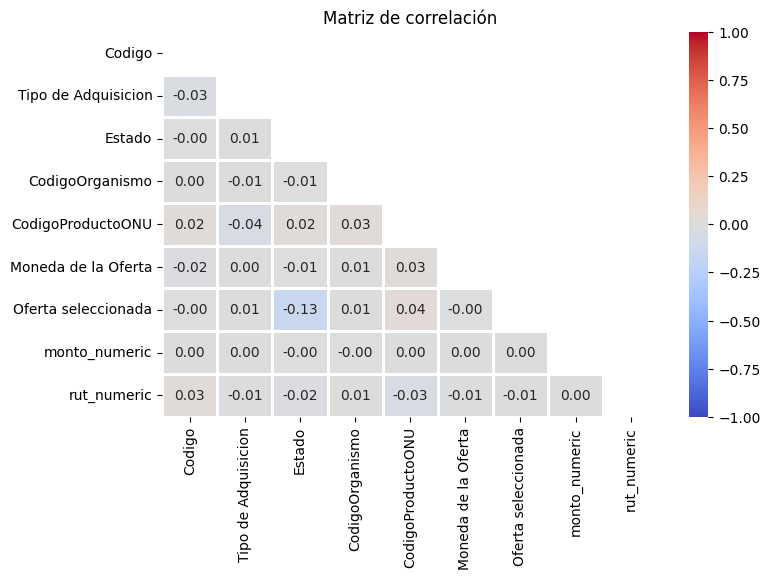

In [22]:
## Matriz de correlacion 
plt.figure(figsize = (8,5))
plt.title('Matriz de correlación')

mask = np.triu(np.ones_like(df_copy.corr(), dtype=np.bool))
sns.heatmap(df_copy.corr(), annot=True, fmt=".2f", vmin=-1, vmax=1, linewidth = 1,
            center=0, mask=mask,cmap="coolwarm") 
plt.show()


In [23]:
df_copy.dtypes[df_copy.dtypes=='int64'].index.to_list()

['Codigo',
 'Tipo de Adquisicion',
 'Estado',
 'CodigoOrganismo',
 'CodigoProductoONU',
 'Moneda de la Oferta',
 'Oferta seleccionada',
 'rut_numeric']

/home/fguzman/miniconda3/envs/mdd/lib/python3.10/site-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


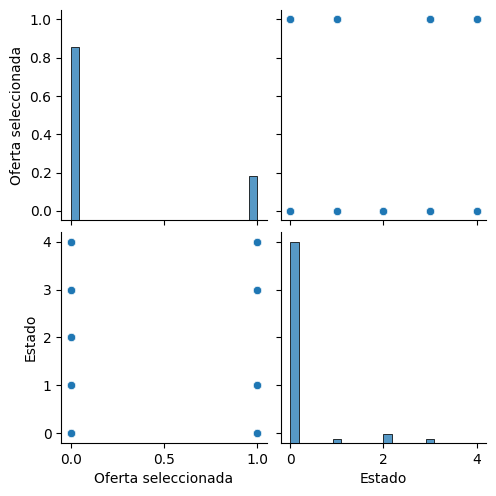

In [24]:
# Se revisa cual es la distribución de las variables numéricas
# sns.set()
cols =['Oferta seleccionada','Estado']
sns.pairplot(df_copy[cols], size = 2.5)

# plt.show()

## Resumen de Analisis exploratorio

- Se observa que los datos solo existen dos campos cuyo valor son nulos (ComunaUnidad, NombreProveedor)
- Existen 3 columnas numericas (Codigo, CodigoOrganismo, CodigoProductoOnu)
- Existen 11 columnas de tipo texto ('Tipo de Adquisicion', 'Estado', 'NombreOrganismo', 'RutUnidad', 'ComunaUnidad', 'FechaPublicacion', 'RutProveedor', 'NombreProveedor', 'Moneda de la Oferta', 'MontoLineaAdjudica', 'Oferta seleccionada')
- los datos de texto más relevantes para el analisis son:
  - ['Tipo de Adquisicion', 'Estado', 'Moneda de la Oferta', 'Oferta seleccionada', 'RutProveedor]
- Se aplican conversiones (encoder) para los datos de texto relevantes para identificar si existe correlacion
- No se aprecia una correlación entre los datos (correlación baja)
- Al comparar la distribución de los datos entre las variables de estado y oferta seleccionada no se aprecia ningun tipo de distribución

## Hipotesis

### La cantidad de oferentes que se presentan en unitario a una licitación representan una caracteristica que puede ser un patrón potencial de corrupción


In [9]:
df_copy = df_read.copy()

## Seleccion de empresas Parte1

In [5]:
# Agrupamos las licitaciones por codigo de licitacion y contamos los oferentes que se participaron
df_empresas_x_licitacion = df_copy[['Codigo','RutProveedor']].groupby(by=['Codigo']).size().reset_index().rename(columns={0:'Cantidad_oferentes'})

In [6]:
df_empresas_x_licitacion.sort_values(by='Cantidad_oferentes', ascending=False)

,Codigo,Cantidad_oferentes
1920,8636096,4792
59412,8715117,3012
746,8632917,2780
8837,8646101,2499
18699,8659604,2401
...,...,...
5703,8641679,1
58340,8713692,1
14788,8654339,1
58355,8713710,1


In [7]:
## Seleccionamos las licitaciones en donde solo participa 1 oferente
datos_a_ocupar = df_empresas_x_licitacion[df_empresas_x_licitacion.Cantidad_oferentes==1]
codigos_licitaciones = datos_a_ocupar.Codigo.to_list()

## Generación de la red


## Con 3 oferentes


In [8]:
## Seleccionamos las licitaciones en donde solo participa 1 oferente
datos_a_ocupar_x_3 = df_empresas_x_licitacion[df_empresas_x_licitacion.Cantidad_oferentes<4]
codigos_licitaciones = datos_a_ocupar_x_3.Codigo.to_list()

In [9]:
df_solo_3_empresas = df_copy[df_copy.Codigo.isin(codigos_licitaciones)]

In [10]:
len(df_solo_3_empresas)

84806

In [11]:
df_solo_3_empresas.columns

Index(['Codigo', 'Tipo de Adquisicion', 'Estado', 'CodigoOrganismo',
       'NombreOrganismo', 'RutUnidad', 'ComunaUnidad', 'FechaPublicacion',
       'CodigoProductoONU', 'RutProveedor', 'NombreProveedor',
       'Moneda de la Oferta', 'MontoLineaAdjudica', 'Oferta seleccionada'],
      dtype='object')

In [12]:
df_solo_3_empresas['Estado_numeric']= df_solo_3_empresas[['Estado']].apply(LabelEncoder().fit_transform)

/tmp/ipykernel_21614/2961590047.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_solo_3_empresas['Estado_numeric']= df_solo_3_empresas[['Estado']].apply(LabelEncoder().fit_transform)


### Visualizando los datos

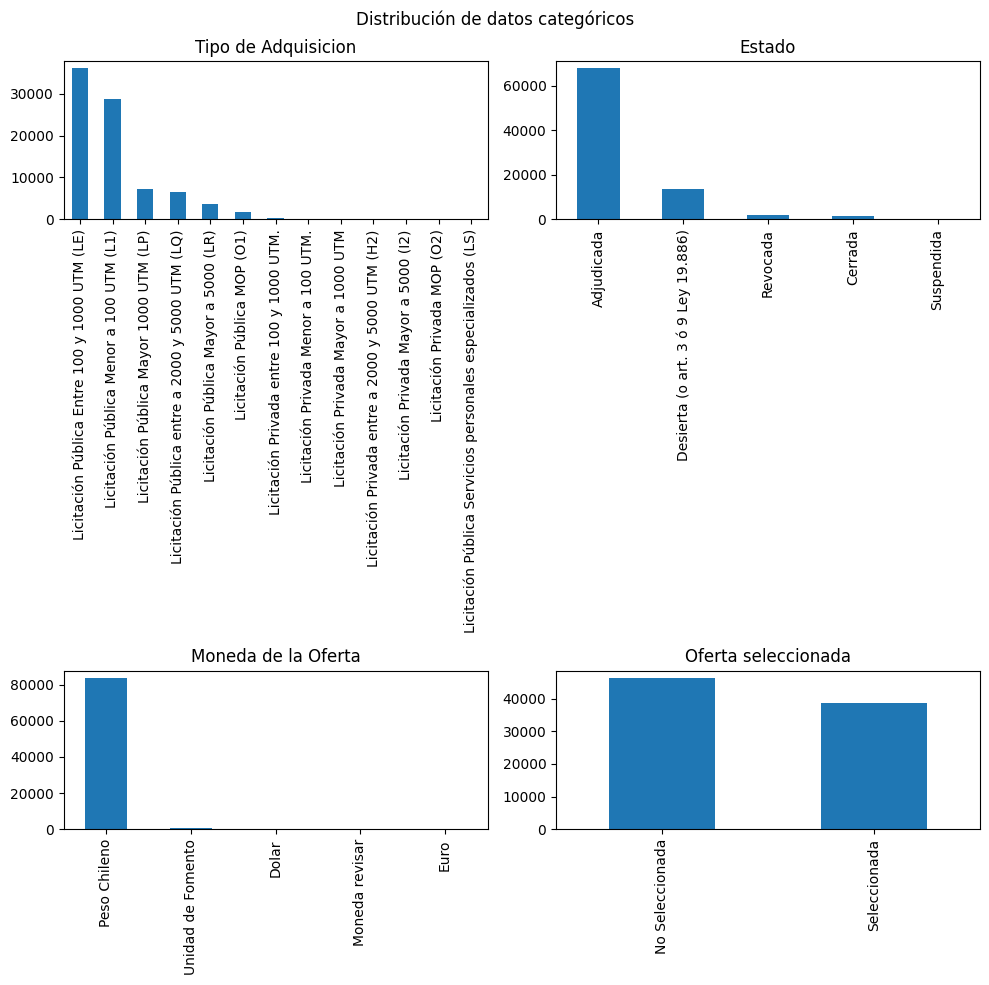

In [54]:
fig, axes = plt.subplots(2,2, figsize=(10,10))
cat_features = ['Tipo de Adquisicion', 'Estado', 'Moneda de la Oferta', 'Oferta seleccionada']
plt.suptitle('Distribución de datos categóricos')
for c,i in enumerate(cat_features):
    if c < 2:  
        df_solo_3_empresas[i].value_counts().plot(kind='bar', ax=axes[0,c]).set_title(i)
    else:
        df_solo_3_empresas[i].value_counts().plot(kind='bar', ax=axes[1,c-2]).set_title(i)
    
    
plt.tight_layout()
plt.show()

### Filtrando los datos

In [55]:
df_solo_3_empresas_1erFiltro = df_solo_3_empresas[(df_solo_3_empresas['Oferta seleccionada']=="Seleccionada") & (df_solo_3_empresas['Estado']=='Adjudicada')]
# Estado=="Adjudicada" and "Oferta seleccionada" =="Seleccionada"'

In [56]:
len(df_solo_3_empresas_1erFiltro)

38478

In [58]:
columnas_filter = ['CodigoOrganismo','RutProveedor','Estado']
df_solo_3_empresas_1erFiltro=df_solo_3_empresas_1erFiltro[columnas_filter].groupby(by=['CodigoOrganismo','RutProveedor']).Estado.count().reset_index()

In [59]:
df_solo_3_empresas_1erFiltro.sort_values(by='Estado', ascending=False)

,CodigoOrganismo,RutProveedor,Estado
1840,6957,91.546.000-3,47
10001,7436,76.666.950-6,33
1827,6957,83.002.400-k,33
1869,6957,96.945.670-2,31
6195,7248,92.264.000-9,28
...,...,...,...
10091,7451,10.016.142-7,1
10090,7450,76.124.890-1,1
10089,7450,13.854.013-8,1
10084,7448,79.622.060-0,1


In [60]:
df_solo_3_empresas_1erFiltro = df_solo_3_empresas_1erFiltro[['CodigoOrganismo','RutProveedor','Estado']].query('Estado >10')

In [61]:
df_solo_3_empresas_1erFiltro = df_solo_3_empresas_1erFiltro.sort_values(by='CodigoOrganismo').reset_index(drop=True)

In [62]:
df_solo_3_empresas_1erFiltro

,CodigoOrganismo,RutProveedor,Estado
0,6918,73.187.600-2,15
1,6946,76.084.712-7,14
2,6946,76.990.883-8,13
3,6957,96.981.250-9,12
4,6957,96.945.670-2,31
...,...,...,...
82,116738,76.339.682-7,14
83,117584,65.020.623-1,15
84,127036,76.193.361-2,17
85,220665,78.566.250-4,21


In [63]:
G = nx.DiGraph() 
for row in df_solo_3_empresas_1erFiltro.index:
    G.add_edge(df_solo_3_empresas_1erFiltro['CodigoOrganismo'][row],df_solo_3_empresas_1erFiltro['RutProveedor'][row],weight=df_solo_3_empresas_1erFiltro['Estado'][row])

In [64]:
pos = nx.spring_layout(G)

In [65]:
#G.degree

In [71]:

best_partition, Q = fast_greedy(G)
print("La mejor partición encontrada consiste en {0} comunidad{1}:".format(
        len(best_partition), "" if len(best_partition) == 1 else "es"))
# for c in best_partition:
    # print(c)
print("La modularidad de esta particion es:", Q)

La mejor partición encontrada consiste en 31 comunidades:
La modularidad de esta particion es: 0.7903289734443121


In [72]:
i=0
colores = []
for c in best_partition:
    i+=1
    if len(c)>10:
        print(i)
        colores.append('red')
    else:
        colores.append('green')

    # print(f"Tamaño comunidad {i}: {len(c)}") 

30
31


### Grafico primera red

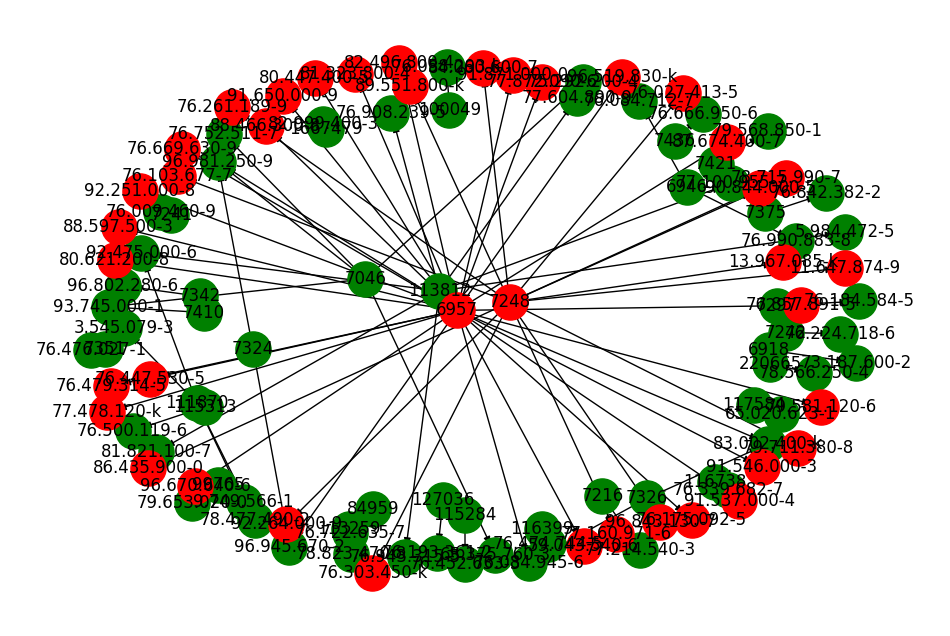

In [73]:
#  = best_partition

# colors = ['red', 'cyan','blue']

plt.figure(figsize=(12,8))
nx.draw_networkx_edges(G, pos)

for community, color in zip(best_partition, colores):
    nx.draw_networkx_nodes(G, pos=pos, nodelist=community, node_color=color, node_size=640)
nx.draw_networkx_labels(G, pos=pos)
_ = plt.axis('off')

In [74]:
#df_solo_3_empresas[df_solo_3_empresas['CodigoOrganismo']==7248]

In [ ]:
# import community

# partition = community_louvain.best_partition(g)
# pos = nx.spring_layout(g)
# color=colores(partition.values())
# nx.draw_networkx_edges(g, pos=pos)
# nx.draw_networkx_nodes(g, pos=pos, node_color=color, node_size=800)
# nx.draw_networkx_labels(g, pos=pos)

## Grafo bipartite


In [75]:
from networkx.algorithms import bipartite
G = nx.Graph()

In [76]:
df_solo_3_empresas_1erFiltro['Tupla'] = list(zip(df_solo_3_empresas_1erFiltro.CodigoOrganismo, df_solo_3_empresas_1erFiltro.RutProveedor))

In [77]:
G.add_nodes_from(df_solo_3_empresas_1erFiltro.CodigoOrganismo.to_list(), bipartite=0)
G.add_nodes_from(df_solo_3_empresas_1erFiltro.RutProveedor.to_list(), bipartite=1)
G.add_edges_from(df_solo_3_empresas_1erFiltro.Tupla.to_list())

https://www.askpython.com/python/examples/bipartite-graph-in-python

In [78]:
bipartite.is_bipartite(G)

True

In [79]:
# df_solo_3_empresas_1erFiltro.Tupla.to_list()

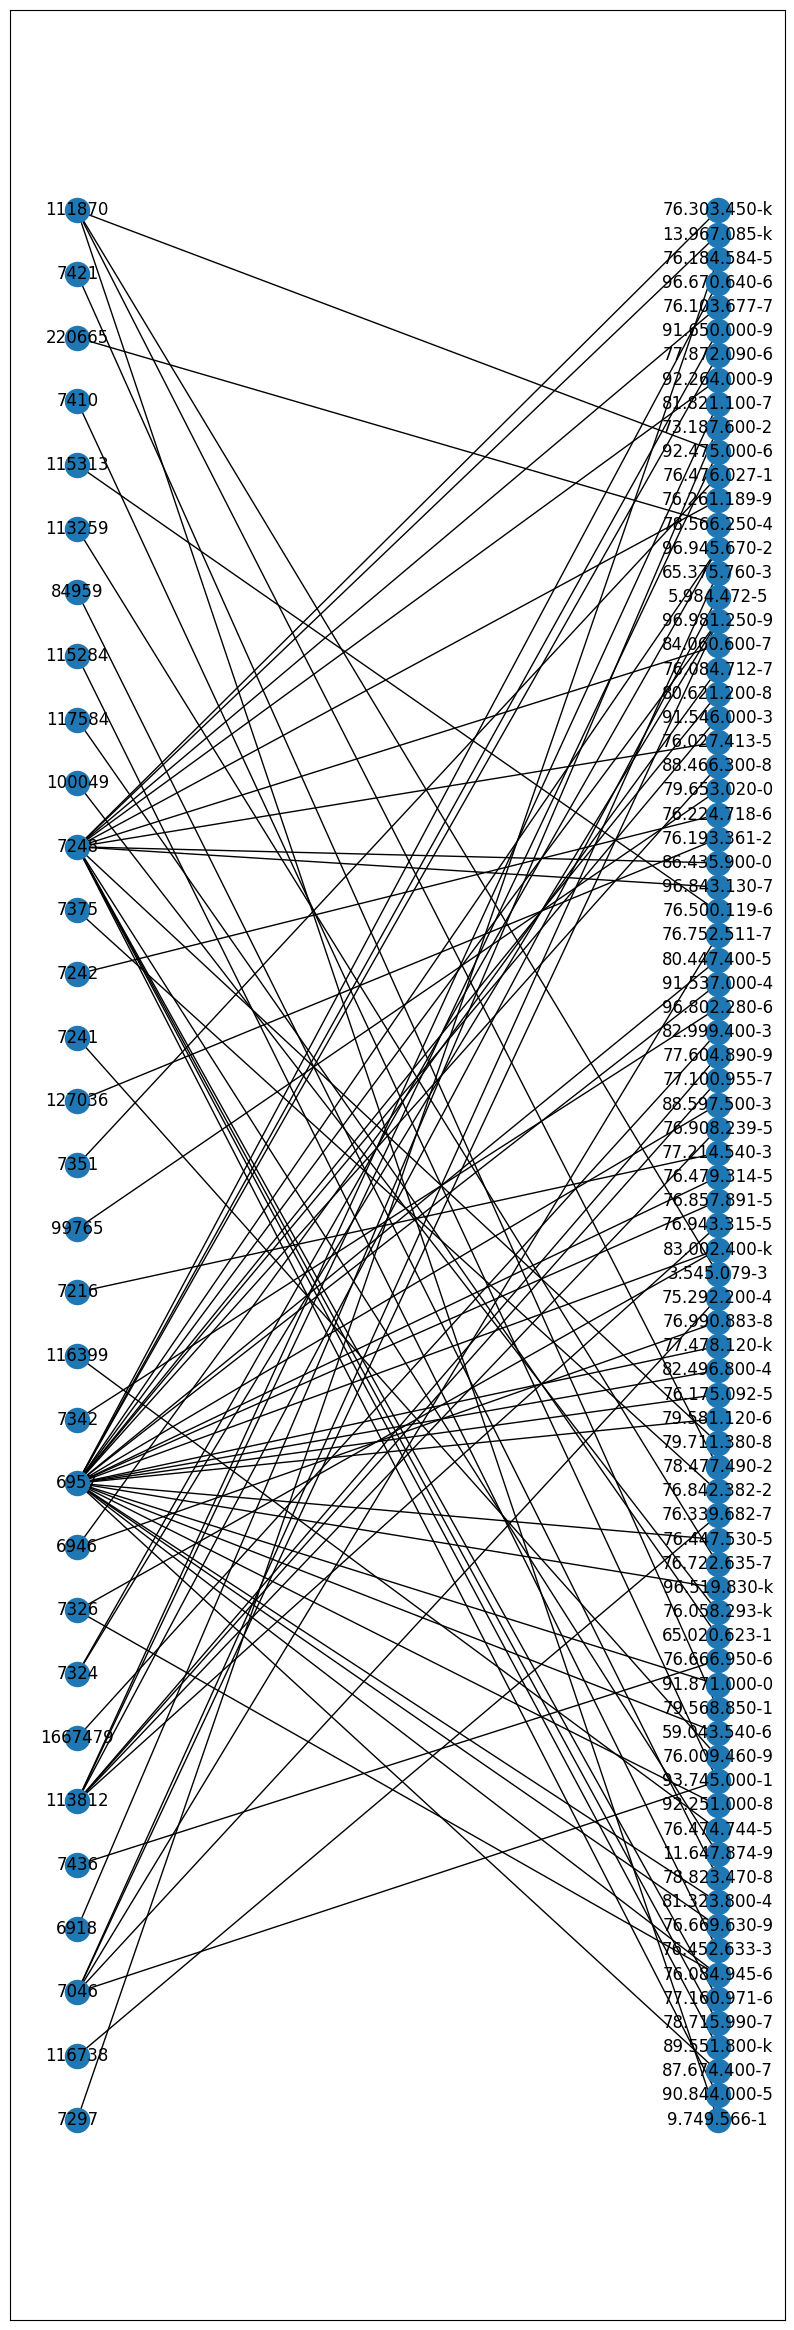

In [81]:
plt.figure(figsize=(10,30))
list_= df_solo_3_empresas_1erFiltro.CodigoOrganismo.to_list()
nx.draw_networkx(G, pos = nx.drawing.layout.bipartite_layout(G, list_))
plt.show()



In [82]:
df_solo_3_empresas_1erFiltro

,CodigoOrganismo,RutProveedor,Estado,Tupla
0,6918,73.187.600-2,15,"(6918, 73.187.600-2)"
1,6946,76.084.712-7,14,"(6946, 76.084.712-7)"
2,6946,76.990.883-8,13,"(6946, 76.990.883-8)"
3,6957,96.981.250-9,12,"(6957, 96.981.250-9)"
4,6957,96.945.670-2,31,"(6957, 96.945.670-2)"
...,...,...,...,...
82,116738,76.339.682-7,14,"(116738, 76.339.682-7)"
83,117584,65.020.623-1,15,"(117584, 65.020.623-1)"
84,127036,76.193.361-2,17,"(127036, 76.193.361-2)"
85,220665,78.566.250-4,21,"(220665, 78.566.250-4)"


In [83]:
df_solo_3_empresas_1erFiltro['CodigoOrganismoTXT'] = df_solo_3_empresas_1erFiltro['CodigoOrganismo'].astype('str')

In [84]:
df_solo_3_empresas_1erFiltro.dtypes

CodigoOrganismo        int64
RutProveedor          object
Estado                 int64
Tupla                 object
CodigoOrganismoTXT    object
dtype: object

In [85]:
# Create a graph from a pandas dataframe
G = nx.from_pandas_edgelist(df_solo_3_empresas_1erFiltro, 
                            source = "RutProveedor", 
                            target = "CodigoOrganismoTXT", 
                            edge_attr = "Estado", 
                            create_using = nx.Graph())

In [86]:
df_solo_3_empresas_1erFiltro

,CodigoOrganismo,RutProveedor,Estado,Tupla,CodigoOrganismoTXT
0,6918,73.187.600-2,15,"(6918, 73.187.600-2)",6918
1,6946,76.084.712-7,14,"(6946, 76.084.712-7)",6946
2,6946,76.990.883-8,13,"(6946, 76.990.883-8)",6946
3,6957,96.981.250-9,12,"(6957, 96.981.250-9)",6957
4,6957,96.945.670-2,31,"(6957, 96.945.670-2)",6957
...,...,...,...,...,...
82,116738,76.339.682-7,14,"(116738, 76.339.682-7)",116738
83,117584,65.020.623-1,15,"(117584, 65.020.623-1)",117584
84,127036,76.193.361-2,17,"(127036, 76.193.361-2)",127036
85,220665,78.566.250-4,21,"(220665, 78.566.250-4)",220665


In [87]:
colores_=[]
for i in df_solo_3_empresas_1erFiltro.Estado:
    if i > df_solo_3_empresas_1erFiltro.Estado.mean():
        colores_.append('red')
    else:
        colores_.append('grey')


In [292]:
# referencia https://github.com/thu-vu92/the_witcher_network

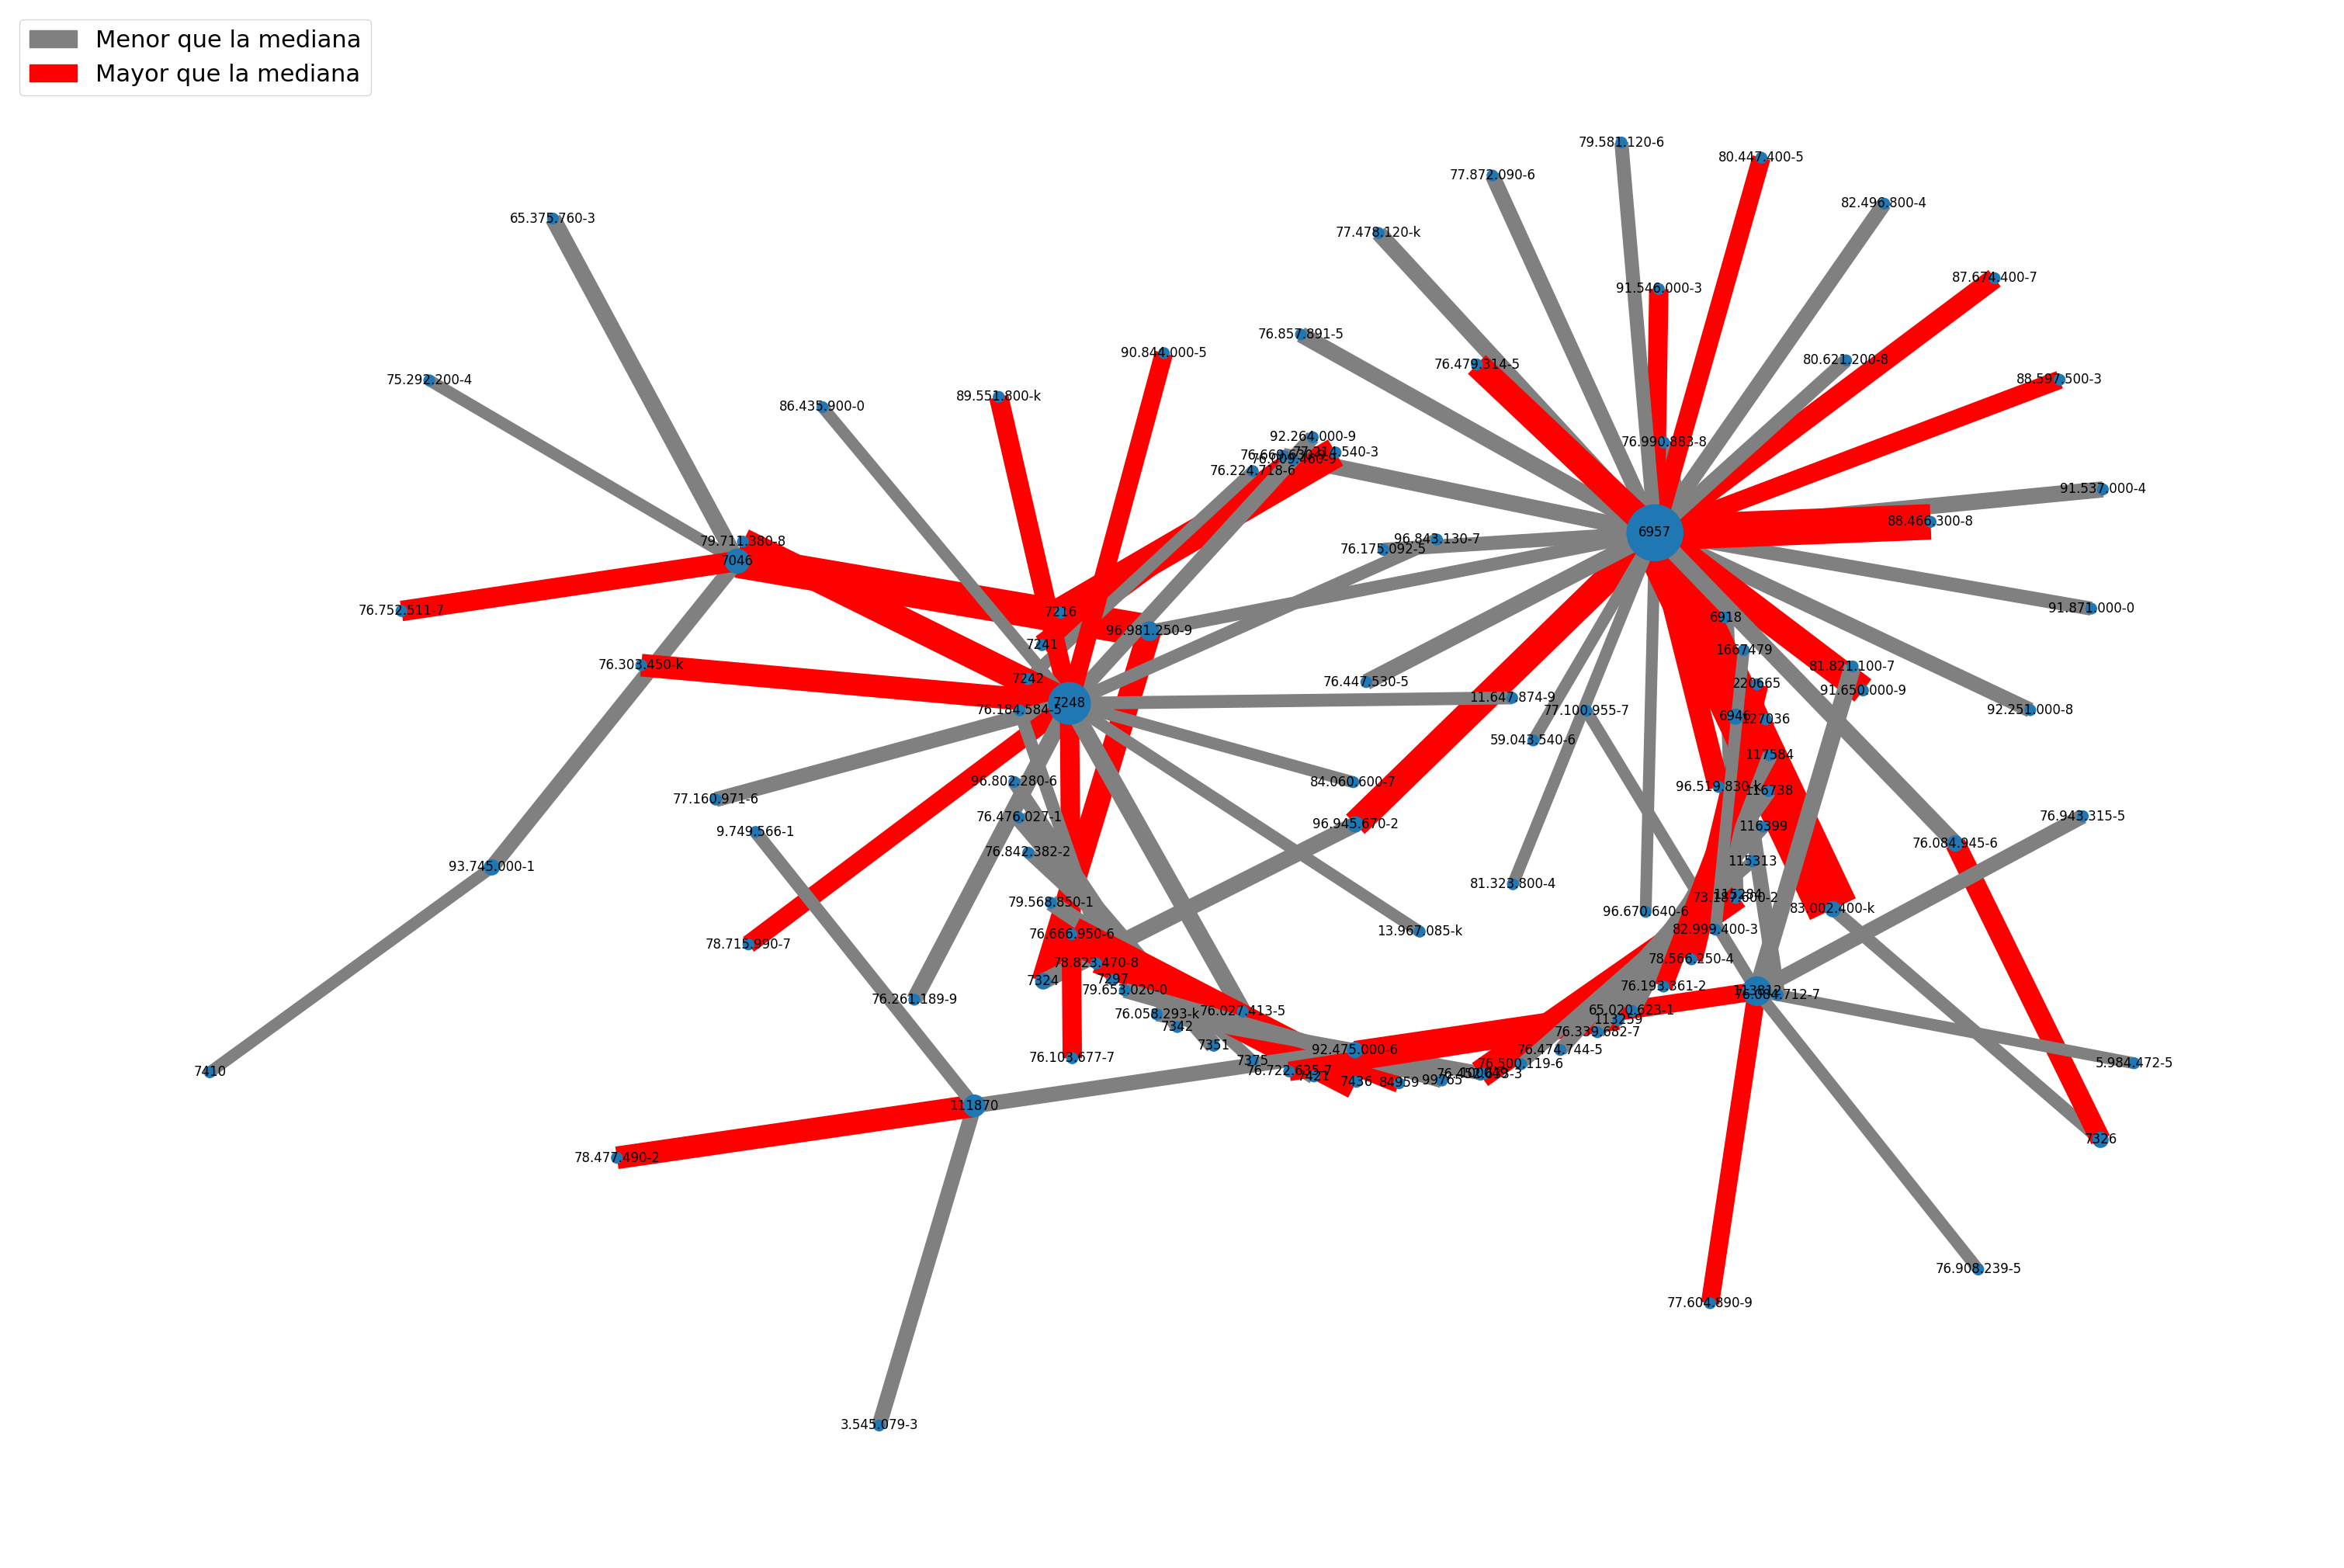

In [88]:
import matplotlib
plt.figure(figsize=(30,20))
degree_g = dict(nx.degree(G))
clustering_g=dict(nx.clustering(G))
edge_widths=df_solo_3_empresas_1erFiltro['Estado'].to_list()
pos = nx.kamada_kawai_layout(G)
nx.draw(G,pos, nodelist=degree_g.keys(), node_size=[v*100 for v in degree_g.values()])
nx.draw(G, pos,with_labels=True,nodelist=clustering_g.keys(), node_size=[v *1000 for v in clustering_g.values()])

nx.draw_networkx_edges(G, pos, edgelist=G.edges(),  edge_color=colores_,width=edge_widths)
patches = [matplotlib.patches.Patch(color='grey', label='Menor que la mediana'),
 matplotlib.patches.Patch(color='red', label='Mayor que la mediana')]
plt.legend(handles=patches,  loc='upper left', fontsize=22)

# nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

Text(0, 0.5, 'Count')

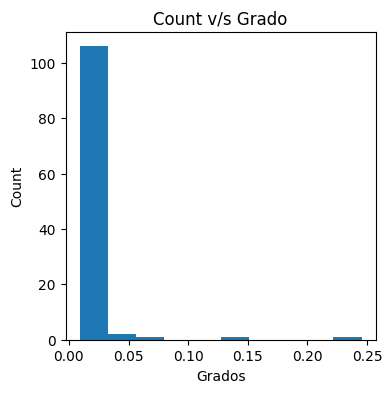

In [92]:
e=nx.degree_centrality(G)
plt.figure(figsize=(4,4))
plt.title('Count v/s Grado')
plt.hist(list(e.values()))
plt.xlabel('Grados')
plt.ylabel('Count')

In [93]:
N = len(G)
L = G.size()
degrees = list(dict(G.degree()).values())
kmin = min(degrees)
kmax = max(degrees)

print("Número de nodos: ", N)
print("Número de enlaces: ", L)
print('-------')
print("Grado promedio: ", 2*L/N) #Formula vista en clases (qué sucedía con las redes reales?)
print("Grado promedio (alternativa de calculo)", np.mean(degrees))
print('-------')
print("Grado mínimo: ", kmin)
print("Grado máximo: ", kmax)

Número de nodos:  111
Número de enlaces:  87
-------
Grado promedio:  1.5675675675675675
Grado promedio (alternativa de calculo) 1.5675675675675675
-------
Grado mínimo:  1
Grado máximo:  27


In [94]:
# Generamos 10 bins espaciados logaritmicamente entre kmin y kmax
bin_edges = np.logspace(np.log10(kmin), np.log10(kmax), num=20)
bin_edges
# histograma de la data para esos bines
density1, _ = np.histogram(degrees, bins=bin_edges, density=True)

In [95]:
bin_edges

array([ 1.        ,  1.18941917,  1.41471797,  1.68269268,  2.00142693,
        2.38053557,  2.83145465,  3.36778645,  4.00570977,  4.764468  ,
        5.66694959,  6.7403785 ,  8.01713542,  9.53573458, 11.34198554,
       13.49037507, 16.04571076, 19.08507602, 22.70015534, 27.        ])

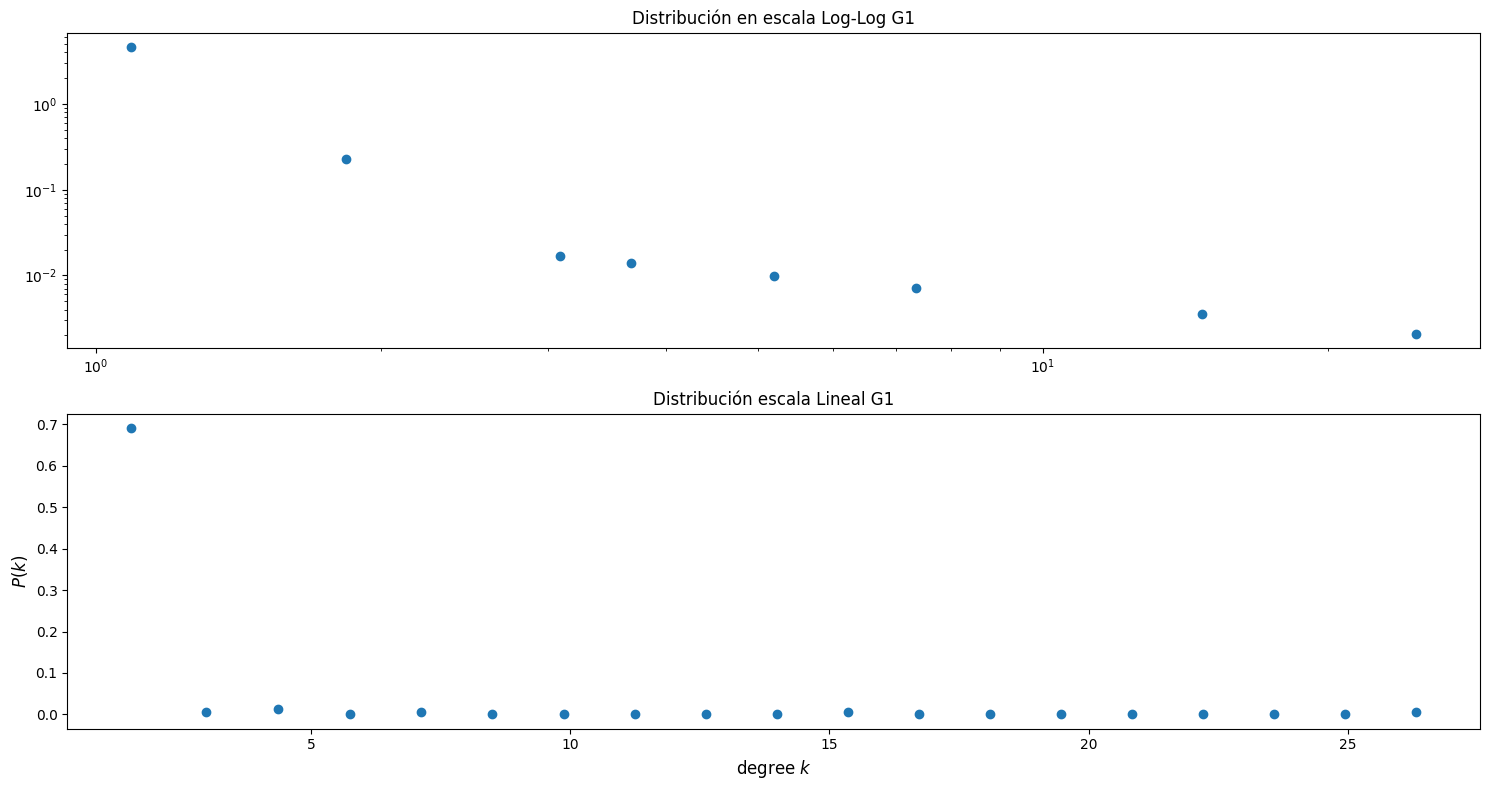

In [96]:
def calculo_log(bin_edges__):
    log_be = np.log10(bin_edges__)
    x = 10**((log_be[1:] + log_be[:-1])/2)
    return x

def calculo_lineal(kmin_, kmax_, degrees_, num_=20 ):
    # Entrega 20 bins linealmente espaceados entre kmin y kmax
    bin_edges___ = np.linspace(kmin_, kmax_, num=num_)
    # histograma de la data en estos bines 
    density___, _ = np.histogram(degrees_, bins=bin_edges___, density=True)
    log_be = np.log10(bin_edges___)
    x = 10**((log_be[1:] + log_be[:-1])/2)
    return x, density___



fig, axes = plt.subplots(2,1, figsize=(15,8))

### Plot Log-log
x1 =calculo_log(bin_edges)

axes[0].loglog(x1, density1, marker='o', linestyle='none')
axes[0].set_title('Distribución en escala Log-Log G1')
plt.xlabel(r"degree $k$", fontsize=12)
plt.ylabel(r"$P(k)$", fontsize=12)


# axes[0,1].set_title('Distribución escala Log-Log G2')
# plt.xlabel(r"degree $k$", fontsize=12)
# axes[0,1].set_ylabel(r"$P(k)$", fontsize=12)

## Plot Lineal
x1, density1= calculo_lineal(kmin, kmax,degrees)


axes[1].plot(x1, density1, marker='o', linestyle='none')
axes[1].set_xlabel(r"degree $k$", fontsize=12)
# .xlabel(r"degree $k$", fontsize=12)
plt.ylabel(r"$P(k)$", fontsize=12)
axes[1].set_title('Distribución escala Lineal G1')


# plt.xlabel(r"degree $k$", fontsize=12)
# plt.ylabel(r"$P(k)$", fontsize=12)
# axes[1,1].set_title('Distribución escala Lineal G2')


plt.tight_layout()

In [97]:
from pyvis.network import Network
net = Network(notebook = True, width="1000px", height="1000px", bgcolor='#222222', font_color='white')

node_degree = dict(G.degree)

#Setting up node size attribute
nx.set_node_attributes(G, node_degree, 'size')


# i=0
# for edge in G.edges():
#     print(edge[0], edge[1])
#     net.add_edge(edge[0], edge[1], width=df_solo_3_empresas_1erFiltro.loc[i,'Estado'])# G.nodes[edge[0]]['size'] + G.nodes[edge[1]]['size'])
#     i +=1
# net.from_nx(G)
net.show("witcher.html")

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


In [98]:
# G.nodes()

In [99]:
# df_solo_3_empresas_1erFiltro

In [100]:
# Degree centrality
degree_dict = nx.degree_centrality(G)
# degree_dict

<AxesSubplot:>

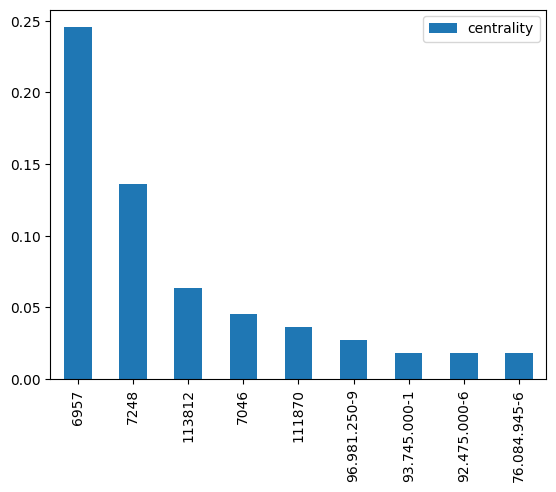

In [101]:
degree_df = pd.DataFrame.from_dict(degree_dict, orient='index', columns=['centrality'])
# Plot top 10 nodes
degree_df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar")

<AxesSubplot:>

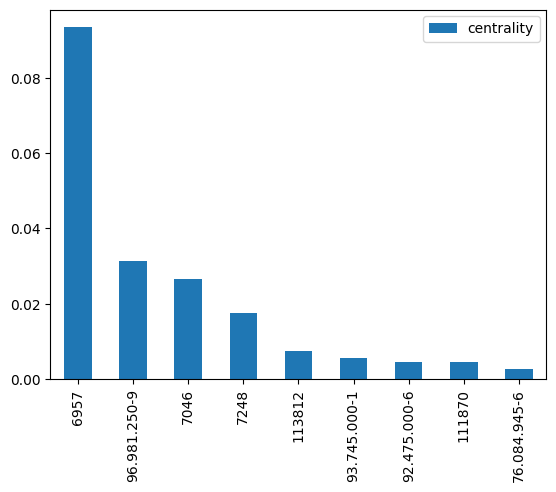

In [102]:
# Betweenness centrality
betweenness_dict = nx.betweenness_centrality(G)
betweenness_df = pd.DataFrame.from_dict(betweenness_dict, orient='index', columns=['centrality'])
# Plot top 10 nodes
betweenness_df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar")


<AxesSubplot:>

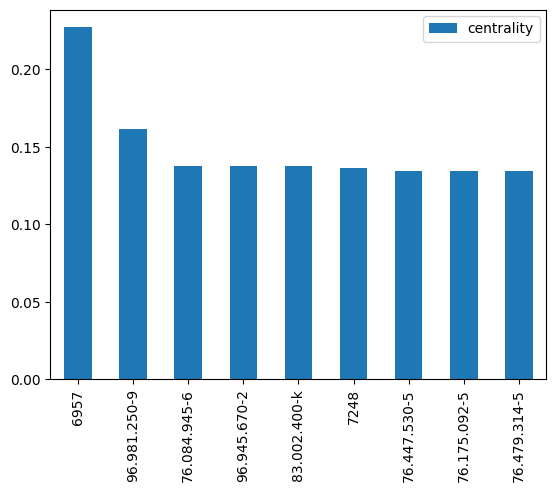

In [103]:
# Closeness centrality
closeness_dict = nx.closeness_centrality(G)
closeness_df = pd.DataFrame.from_dict(closeness_dict, orient='index', columns=['centrality'])
# Plot top 10 nodes
closeness_df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar")

In [104]:
# Save centrality measures
nx.set_node_attributes(G, degree_dict, 'degree_centrality')
nx.set_node_attributes(G, betweenness_dict, 'betweenness_centrality')
nx.set_node_attributes(G, closeness_dict, 'closeness_centrality')

In [105]:
import community as community_louvain

In [106]:
communities = community_louvain.best_partition(G)

In [107]:
# communities

In [108]:
nx.set_node_attributes(G, communities, 'group')

In [109]:
com_net = Network(notebook = True, width="1000px", height="700px", bgcolor='#222222', font_color='white')
com_net.from_nx(G)
com_net.show("witcher_communities.html")

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 
